# Disphonic Voice Pattern Analysis of Patients in Parkinson's Diseasing Using Minimum Interclass Probability Risk Feature Selection and Bagging Ensemble Learning Method.

Dataset: http://archive.ics.uci.edu/ml/datasets/Parkinsons

Research paper: Research Paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5434464/

Must haves:
- Load, inspect and clean data.
- Split data into training, validation and test set.
- Use a simple classifier as baseline.
- Train various classifiers.
- Motivate your choice in relation to the characteristics of the dataset.
- Combine classifiers into ensemble learning, that outperforms others.

Assessment:
- Conduct critical research:
	- Critical evaluation and justification: 
		- excellent and critical use of research and design methodologies.  
		- Very clear and validated design. **Create a pipeline**
		- Critical attitude towards own results, literature and specialists. **Read paper**
	- Evaluate obtained solutions:
		- Detailed interpretation and verification of the results.
		- Conclusions based on the results in a clear way.
		- Conclusions are extrapolated to a wider context. **How can results be applied? What do they say in a wider context?**
- Model meaningful information
	- Quality of work
		- Results are extracted from correct analysis of data. **What analysis methods are to be used? Show visualizations (see example codes decision vector etc.)**
		- Used algorithms are (cross) validated, evaluated and optimized. **Cross validation, create sklearn pipeline**
		- The outcome of the research enhances knowledge of the topic. **How does does the outcome enhance the knowledge of the topic?**
- Delivered organised solutions
	- Code repository and code:
		- Code according to coding style. **What style to use?**
		- Code is exceptionally easy to read and maintain. **Create python documentation automatically?**
		- All the code is stored in a repository according logic structure with self explainable README file.
		- Complete instructions and version information.
		- Used software is suitably licensed. **What licence? MIT?**

# Article summary


# Data characteristics
- How to deal with imbalanced datasets? https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

# Plan of Attack
1. Frame the problem
2. Collect the data
3. Load the data
4. Exploratory data analysis
5. Prepare the data
6. Split the data
7. Train model
8. Use model to predict
9. Evaluate model
10. Fine tune model
11. Present solution
12. Conclusion


# 1. Overview

Dysphonia is a disorder that causes difficulties in voice production. It can be observed with the use of vowel sounds. About 70-80% of Idopathic Parkinson's disease (IPD) patients suffer from dysphonia. The quantification of vocal parameters helps in understanding disease progression.

Patients with IDP have significant phonetic variability in comparison with healthy controls.

It is of importance to be able to identify patients that have IDP, to be able to treat it. This can be predicted by a model that learns the vocal parameters.

**Current solutions**:
- Logistic regression
- Support vector machine
- Bagging ensemble

**Problem frame**:

It is a *model-based offline* *supervised* *classification* problem. We have to classify healthy participants and participants with IDP. This requires pattern detection in the training data to build a predictive model. It is a binary classification problem.

**Performance measure**:

The dataset is imbalanced, therefore accuracy may not be the best measure. 

It is important to find patients with IDP. Therefore, we want as much true positives and true negatives as possible. False positives are not as good, but won't pose a big problem, as someone would need to do additional tests. False negatives are detrimental and should not occur. It will cause harm if someone has IDP but it is not predicted.

The ROC-curve is also usefull for imbalanced classes and it provides a visual trade-off between FPR and TPR.

Thus, measures that should be used are:
- Sensitivity (true positive rate)
- Recall/sensitivity (true negative rate)
- ROC-curve 

The performance measures are aligned with the business objective to distinguish between healthy patients and IDP patients.

**Minimum performance**:

Wu et al. achieved a high AUC of 0.9558 using Bagging with ICPR features, and a sensitvity of 0.9796. They used specific feature extraction techniques that contributed to their result. In this project we aim to get AUC and sensitivity of atleast 0.9. 

# 2. Collect the data

The phonation data was provided by Little et al. for public research usage. It is available <a href="http://archive.ics.uci.edu/ml/datasets/Parkinsons" target="_blank">here</a>.

Characteristics of the data:
- Multivariate
- Number of instances: 197
- Number of attributes: 23
- Associated task: classification
- 39.7 KB file, 48.56 KB dataframe memory

The dataset is composed of biomedical voice measurements from 31 people, 23 with Parkinson's disease. Each column is a voice measure, each row corresponds to one of 195 recordings from the particpants (`name` variable). The aim is to discriminate healthy people from people with PD.

Source:

The dataset was created by Max Little of the University of Oxford, in 
collaboration with the National Centre for Voice and Speech, Denver, 
Colorado, who recorded the speech signals. The original study published the 
feature extraction methods for general voice disorders.

Reference:

'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection', 
Little MA, McSharry PE, Roberts SJ, Costello DAE, Moroz IM. 
BioMedical Engineering OnLine 2007, 6:23 (26 June 2007)

## 2.1 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy.stats import boxcox, yeojohnson

from sklearn.model_selection import StratifiedShuffleSplit
%matplotlib inline

## 2.2 Load data
The file `parkinsons.data` contains tabulat data which can be read into a DataFrame object. The data is separated by `,`.

Once the file is loaded, a manual inspection of `parkinsons.names` can be done to understand the data, as it gives a description of the data. However, I'll also explore `parkinsons.data` later on.

It is important to show the head and tail to look if the data is correctly loaded.

In [2]:
df = pd.read_csv('../data/parkinsons.data', sep=',').set_index('name')

In [3]:
df.head(3)

MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
name                                                                      
phon_R01_S01_1      119.992       157.302        74.997         0.00784   
phon_R01_S01_2      122.400       148.650       113.819         0.00968   
phon_R01_S01_3      116.682       131.111       111.555         0.01050   

                MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  \
name                                                               
phon_R01_S01_1           0.00007   0.00370   0.00554     0.01109   
phon_R01_S01_2           0.00008   0.00465   0.00696     0.01394   
phon_R01_S01_3           0.00009   0.00544   0.00781     0.01633   

                MDVP:Shimmer  MDVP:Shimmer(dB)  ...  Shimmer:DDA      NHR  \
name                                            ...                         
phon_R01_S01_1       0.04374             0.426  ...      0.06545  0.02211   
phon_R01_S01_2       0.06134             0.626  ...      0.09403  0.01929   
phon_R01_S01_3       0.05233             0.482  ...      0.08270  0.01309   

                   HNR  status      RPDE       DFA   spread1   spread2  \
name                                                                     
phon_R01_S01_1  21.033       1  0.414783  0.815285 -4.813031  0.266482   
phon_R01_S01_2  19.085       1  0.458359  0.819521 -4.075192  0.335590   
phon_R01_S01_3  20.651       1  0.429895  0.825288 -4.443179  0.311173   

                      D2       PPE  
name                                
phon_R01_S01_1  2.301442  0.284654  
phon_R01_S01_2  2.486855  0.368674  
phon_R01_S01_3  2.342259  0.332634  

[3 rows x 23 columns]

In [4]:
df.tail(3)

MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
name                                                                      
phon_R01_S50_4      174.688       240.005        74.287         0.01360   
phon_R01_S50_5      198.764       396.961        74.904         0.00740   
phon_R01_S50_6      214.289       260.277        77.973         0.00567   

                MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  \
name                                                               
phon_R01_S50_4           0.00008   0.00624   0.00564     0.01873   
phon_R01_S50_5           0.00004   0.00370   0.00390     0.01109   
phon_R01_S50_6           0.00003   0.00295   0.00317     0.00885   

                MDVP:Shimmer  MDVP:Shimmer(dB)  ...  Shimmer:DDA      NHR  \
name                                            ...                         
phon_R01_S50_4       0.02308             0.256  ...      0.03804  0.10715   
phon_R01_S50_5       0.02296             0.241  ...      0.03794  0.07223   
phon_R01_S50_6       0.01884             0.190  ...      0.03078  0.04398   

                   HNR  status      RPDE       DFA   spread1   spread2  \
name                                                                     
phon_R01_S50_4  17.883       0  0.407567  0.655683 -6.787197  0.158453   
phon_R01_S50_5  19.020       0  0.451221  0.643956 -6.744577  0.207454   
phon_R01_S50_6  21.209       0  0.462803  0.664357 -5.724056  0.190667   

                      D2       PPE  
name                                
phon_R01_S50_4  2.679772  0.131728  
phon_R01_S50_5  2.138608  0.123306  
phon_R01_S50_6  2.555477  0.148569  

[3 rows x 23 columns]

## 2.3 A quick glance

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195 entries, phon_R01_S01_1 to phon_R01_S50_6
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MDVP:Fo(Hz)       195 non-null    float64
 1   MDVP:Fhi(Hz)      195 non-null    float64
 2   MDVP:Flo(Hz)      195 non-null    float64
 3   MDVP:Jitter(%)    195 non-null    float64
 4   MDVP:Jitter(Abs)  195 non-null    float64
 5   MDVP:RAP          195 non-null    float64
 6   MDVP:PPQ          195 non-null    float64
 7   Jitter:DDP        195 non-null    float64
 8   MDVP:Shimmer      195 non-null    float64
 9   MDVP:Shimmer(dB)  195 non-null    float64
 10  Shimmer:APQ3      195 non-null    float64
 11  Shimmer:APQ5      195 non-null    float64
 12  MDVP:APQ          195 non-null    float64
 13  Shimmer:DDA       195 non-null    float64
 14  NHR               195 non-null    float64
 15  HNR               195 non-null    float64
 16  status            195 non

A description of the columns is given in `parkinsons.names`. I added the expected type of the variable:

|Variable |Decsription | expected type |
|------------------------|----------------------------------------| --|
|name ( set as index) | ASCII subject name and recording number | object
|MDVP:Fo(Hz) | Average vocal fundamental frequency | float |
|MDVP:Fhi(Hz) | Maximum vocal fundamental frequency | float |
|MDVP:Flo(Hz) | Minimum vocal fundamental frequency | float |
|MDVP:Jitter(%)<br>MDVP:Jitter(Abs) <br>MDVP:RAP<br>MDVP:PPQ<br>Jitter:DDP | Several measures of variation in fundamental frequency | float |
|MDVP:Shimmer<br>MDVP:Shimmer(dB)<br>Shimmer:APQ3<br>Shimmer:APQ5<br>MDVP:APQ<br>Shimmer:DDA | Several measures of variation in amplitude | float |
|NHR<br>HNR | Two measures of ratio of noise to tonal components in the voice| float |
| status | Health status of the subject (one) - Parkinson's, (zero) - healthy| int |
|RPDE<br>D2 | Two nonlinear dynamical complexity measures| float |
|DFA | Signal fractal scaling exponent| float |
|spread1<br>spread2<br>PPE | Three nonlinear measures of fundamental frequency variation | float |

In [6]:
df.index.dtype

dtype('O')

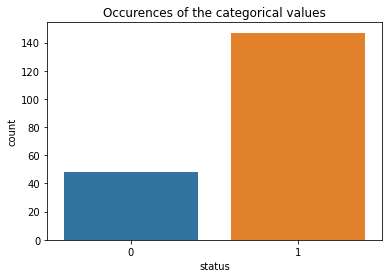

1    147
0     48
Name: status, dtype: int64

In [7]:
plot = sns.countplot(x=df['status'])
plot.set_title("Occurences of the categorical values")

plt.show()

df['status'].value_counts()

        0 is a healthy participant.
        1 is a participant with Parkinson's disease.
        
The data is highly imbalanced.
        
1) The imbalance should be taken into account when modelling the data. Most models expect balanced data and will not be able to model classes that are undersampled accurately.

The data has the types that are expected. `status` is described by an integer $\in 0, 1$. The other columns are of the type `float64` and the index of type `object`.

In [8]:
df.describe()

MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
count   195.000000    195.000000    195.000000      195.000000   
mean    154.228641    197.104918    116.324631        0.006220   
std      41.390065     91.491548     43.521413        0.004848   
min      88.333000    102.145000     65.476000        0.001680   
25%     117.572000    134.862500     84.291000        0.003460   
50%     148.790000    175.829000    104.315000        0.004940   
75%     182.769000    224.205500    140.018500        0.007365   
max     260.105000    592.030000    239.170000        0.033160   

       MDVP:Jitter(Abs)    MDVP:RAP    MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
count        195.000000  195.000000  195.000000  195.000000    195.000000   
mean           0.000044    0.003306    0.003446    0.009920      0.029709   
std            0.000035    0.002968    0.002759    0.008903      0.018857   
min            0.000007    0.000680    0.000920    0.002040      0.009540   
25%            0.000020    0.001660    0.001860    0.004985      0.016505   
50%            0.000030    0.002500    0.002690    0.007490      0.022970   
75%            0.000060    0.003835    0.003955    0.011505      0.037885   
max            0.000260    0.021440    0.019580    0.064330      0.119080   

       MDVP:Shimmer(dB)  ...  Shimmer:DDA         NHR         HNR      status  \
count        195.000000  ...   195.000000  195.000000  195.000000  195.000000   
mean           0.282251  ...     0.046993    0.024847   21.885974    0.753846   
std            0.194877  ...     0.030459    0.040418    4.425764    0.431878   
min            0.085000  ...     0.013640    0.000650    8.441000    0.000000   
25%            0.148500  ...     0.024735    0.005925   19.198000    1.000000   
50%            0.221000  ...     0.038360    0.011660   22.085000    1.000000   
75%            0.350000  ...     0.060795    0.025640   25.075500    1.000000   
max            1.302000  ...     0.169420    0.314820   33.047000    1.000000   

             RPDE         DFA     spread1     spread2          D2         PPE  
count  195.000000  195.000000  195.000000  195.000000  195.000000  195.000000  
mean     0.498536    0.718099   -5.684397    0.226510    2.381826    0.206552  
std      0.103942    0.055336    1.090208    0.083406    0.382799    0.090119  
min      0.256570    0.574282   -7.964984    0.006274    1.423287    0.044539  
25%      0.421306    0.674758   -6.450096    0.174351    2.099125    0.137451  
50%      0.495954    0.722254   -5.720868    0.218885    2.361532    0.194052  
75%      0.587562    0.761881   -5.046192    0.279234    2.636456    0.252980  
max      0.685151    0.825288   -2.434031    0.450493    3.671155    0.527367  

[8 rows x 23 columns]

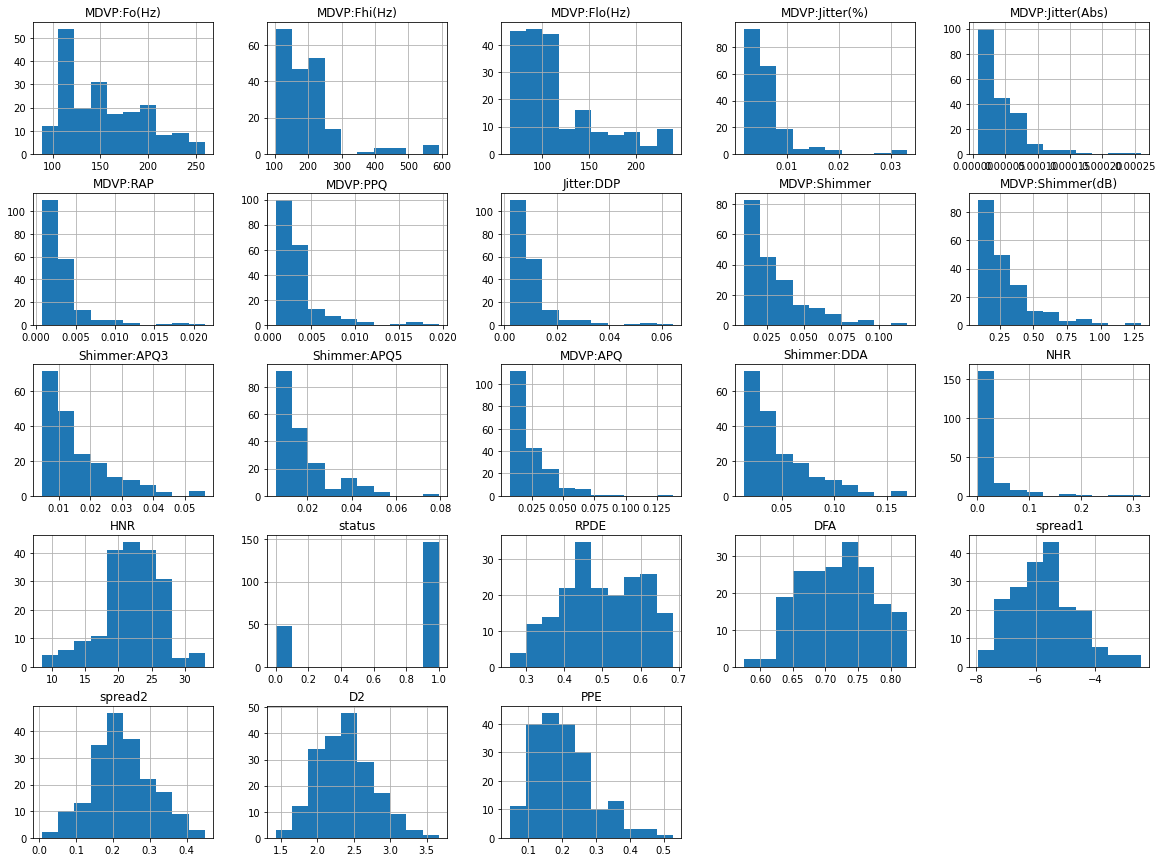

In [9]:
df.hist(figsize=(20, 15))
plt.show()

It can be seen that almost no variables have a normal distribution. The only ones with a normal distribution could be `spread2` and `D2`. The other variables are mostly skewed to the left.

1) The data should be transformed in a later stage for models that expect normally distributed data.

2) The data should also be standardized for specific models, as the data is not scaled.

## 2.4 Sample a test set
This is necessary to prevent analysis bias. It is important that the sets are representative, thus the test set should have the same distribution as the dataset itself. Therefore, we use stratified sampling. The data is divided into strata, and the right number of instances is sampled from each stratum, such that it is representative of the whole dataset.

In [10]:
# original distribution
df['status'].value_counts() / len(df)

1    0.753846
0    0.246154
Name: status, dtype: float64

In [11]:
# split the data in a train set and test set, while preserving the distribution
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=31)
for train_index, test_index in split.split(df, df['status']):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]
    
strat_test_set['status'].value_counts() / len(strat_test_set)

1    0.74359
0    0.25641
Name: status, dtype: float64

# 3. Exploratory data analysis

In [12]:
# start with a copy for visualization
voice = strat_train_set.copy()
voice_healthy = voice[voice['status'] == 0]
voice_idp = voice[voice['status'] == 1]

## 3.1 Visualize

In [13]:
voice['status'] = voice['status'].map({0: "Healthy", 1: "Parkinson's disease"})

In [14]:
# create multiple pairplots for reada
# sns_plot = sns.pairplot(voice, hue='status')
# sns_plot.savefig("pairplot.png")

# plt.clf()

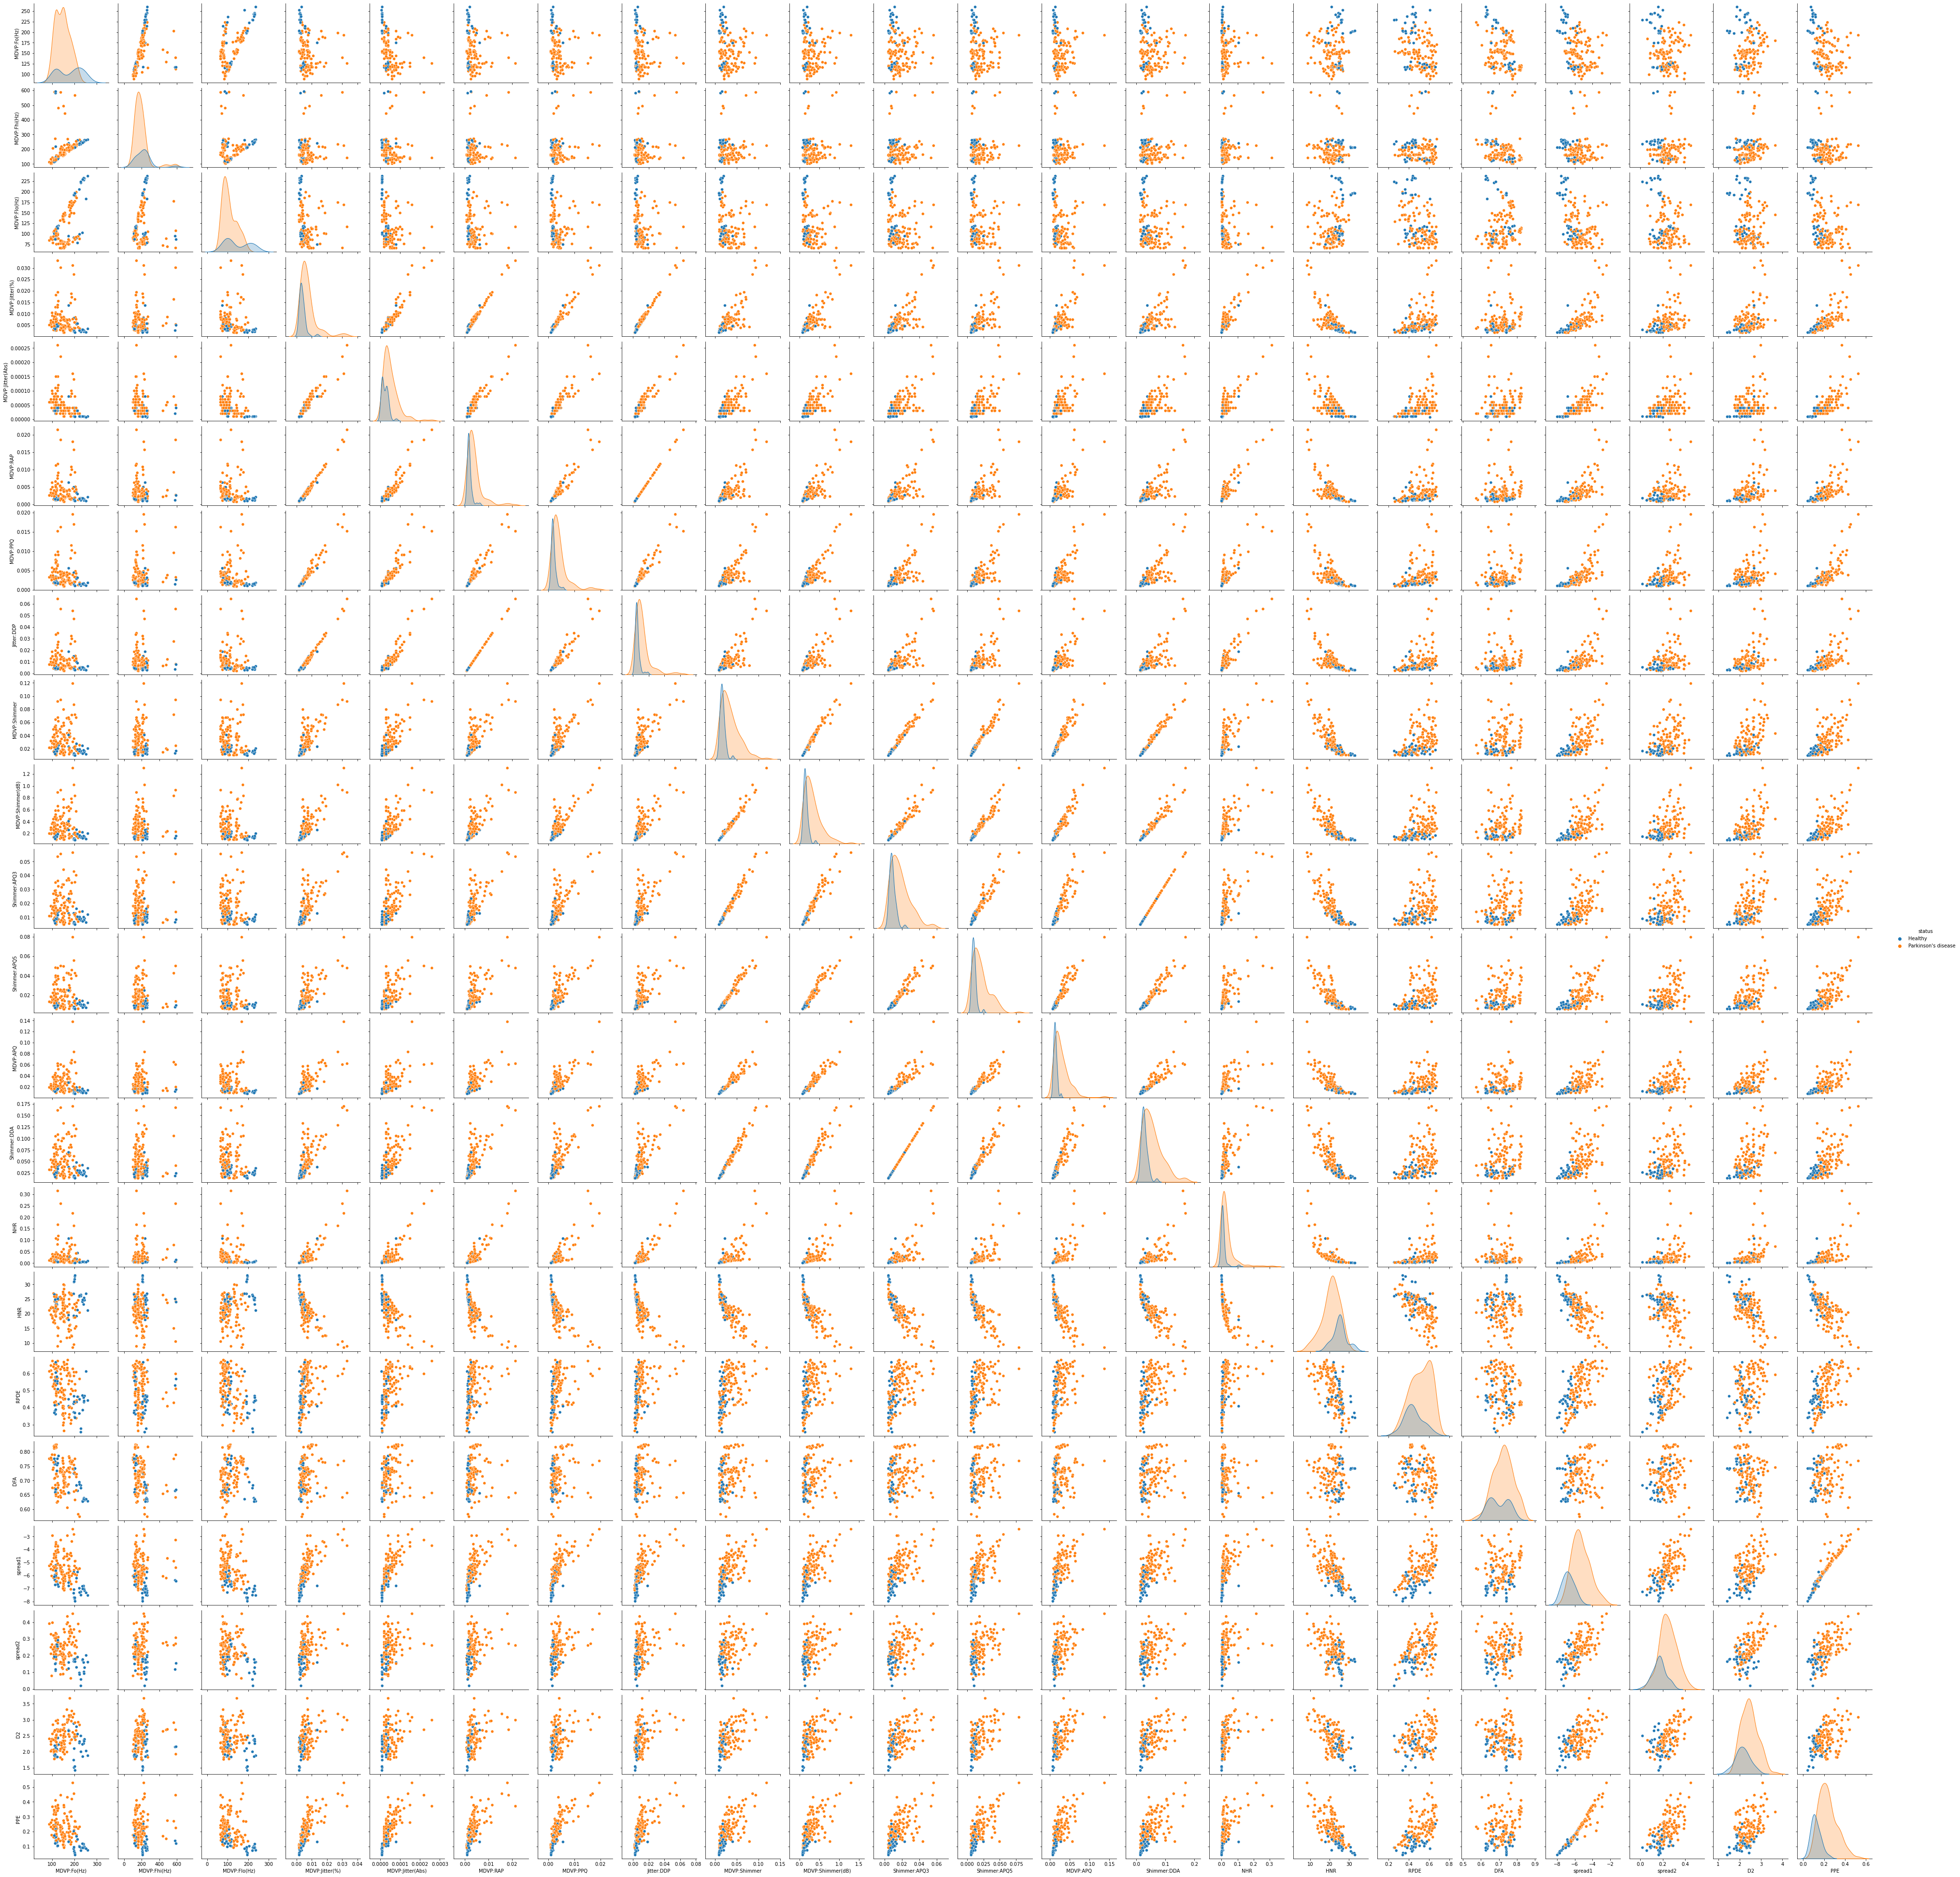

In [15]:
# Easiest to open this in a new tab and zoom in.
Image(filename='pairplot.png')

We can clearly see that the groups are not easily linearly seperable, and seem to be rather non-linear. Most of the times, healthy patients and IDP patients overlap each other.

Some scatterplots look like they are linearly separable, such as `Shimmer:APQ3` and `Shimmer:DDA`. However, most of the values are overlapping each other, as shown in the cells below.

Another observation is that the IDP patients show a much higher variance. This is calculated below. This means that healhy people are mostly clustered together, while IDP patients are not really clustered and are spread out. This also means that each patient develops his own phenotype.

As there are only a few healthy samples, and they are clustered, `SMOTE` may be an interesting algorithm to use.

In [16]:
std_healthy = voice[voice['status'] == "Healthy"].describe().loc['std']
std_idp = voice[voice['status'] == "Parkinson's disease"].describe().loc['std']

In [17]:
((std_healthy - std_idp) < 0).sum()

19

19 out of 23 variables from IDP patients show higher variance than healthy patients.

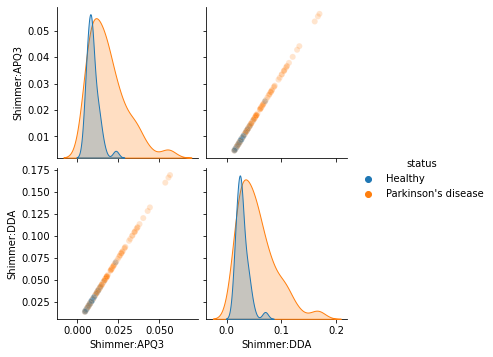

In [18]:
# An example of overlapping values
sns.pairplot(voice, vars=['Shimmer:APQ3', 'Shimmer:DDA'], hue='status',plot_kws={'alpha':0.2})

## 3.2 Check for missing data

In [19]:
voice.isna().sum().sum()

0

There are no missing values, thus no reason to investigate this aspect further.

## 3.3 Check for correlations

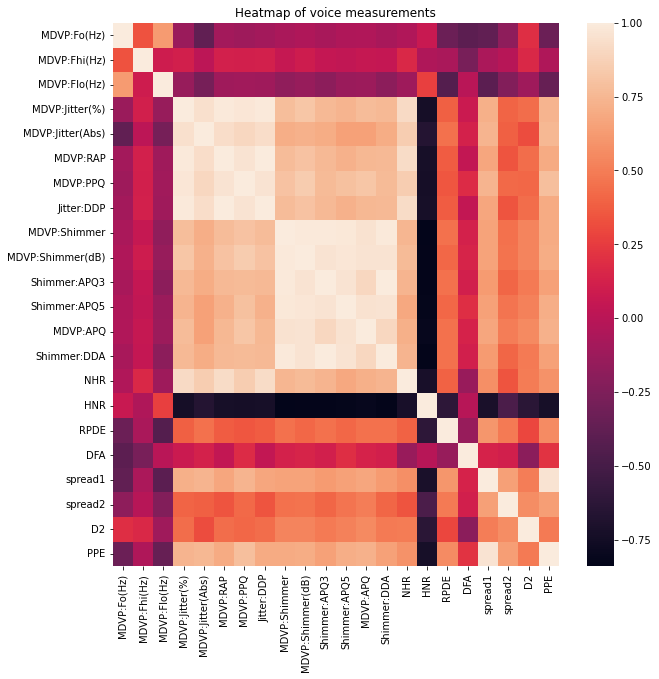

In [20]:
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(voice.corr())
heatmap.set_title('Heatmap of voice measurements')
plt.show()

We can cleary observe highly correlated features. 

What to do with the highly correlated features?
- Remove them if they have a correlation higher than 0.8. This threshold is also used in the article.

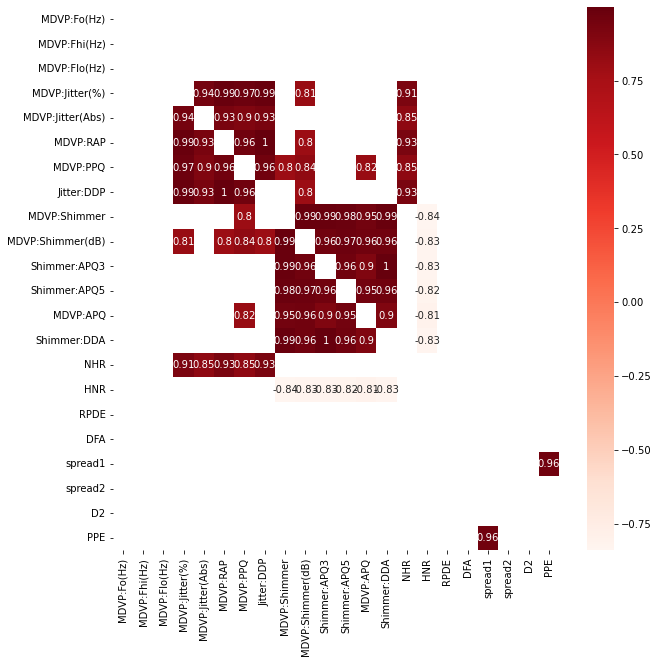

In [21]:
c = voice.corr()

filtered = c[((c >= 0.8) | (c <= -0.8)) & (c != 1.0)]

plt.figure(figsize=(10, 10))
sns.heatmap(filtered, annot=True, cmap="Reds")
plt.show()

In [22]:
flattened = filtered.unstack().sort_values().drop_duplicates()
to_remove = pd.DataFrame(flattened).reset_index()['level_1'].tolist()

filtered_df = voice.drop(to_remove, axis=1)

filtered_df.head()

MDVP:Fhi(Hz)  MDVP:Flo(Hz)               status      RPDE  \
name                                                                        
phon_R01_S42_3       264.919       237.303              Healthy  0.440988   
phon_R01_S44_1       190.204       129.859  Parkinson's disease  0.396610   
phon_R01_S22_2       164.989       142.299  Parkinson's disease  0.454444   
phon_R01_S31_6       198.966        79.512  Parkinson's disease  0.585169   
phon_R01_S24_2       140.557        96.206  Parkinson's disease  0.571010   

                     DFA   spread2        D2       PPE  
name                                                    
phon_R01_S42_3  0.628058  0.160414  1.881767  0.075587  
phon_R01_S44_1  0.745957  0.197919  2.449763  0.132703  
phon_R01_S22_2  0.734504  0.087840  2.344336  0.186489  
phon_R01_S31_6  0.736964  0.115697  1.996146  0.196535  
phon_R01_S24_2  0.690892  0.202146  2.441612  0.260375

In [23]:
filtered_df.columns

Index(['MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'status', 'RPDE', 'DFA', 'spread2',
       'D2', 'PPE'],
      dtype='object')

The columns `MDBP:Fhi(Hz), MDVP:Flo(Hz), Jitter:DDP, status, RPDE, DFA, spread2, D2, PPE` can be used for the model, as they are not correlated.

## 3.4 Check for outliers
Outliers can affect the model and cause wrong measurements.

In [24]:
features = filtered_df
q1 = features.quantile(0.25)
q3 = features.quantile(0.75)
iqr = q3 - q1

outliers_subset = (features < (q1 - 1.5 * iqr)) | (features > (q3 + 1.5 * iqr))
outliers_subset.sum()

/tmp/ipykernel_3880170/2897122554.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers_subset = (features < (q1 - 1.5 * iqr)) | (features > (q3 + 1.5 * iqr))


D2              1
DFA             0
MDVP:Fhi(Hz)    8
MDVP:Flo(Hz)    5
PPE             3
RPDE            0
spread2         3
status          0
dtype: int64

Several outliers are found. Now there is a decision to make:
- Keep the outliers.
- Correct the outliers.
- Remove the outliers.

As outliers can affect some models, it can be good to remove them. However, testing models emperically with and without outliers would be a good strategy.

# 4. Prepare the data

In [25]:
X = filtered_df.drop(columns=['status'])
y = filtered_df['status']

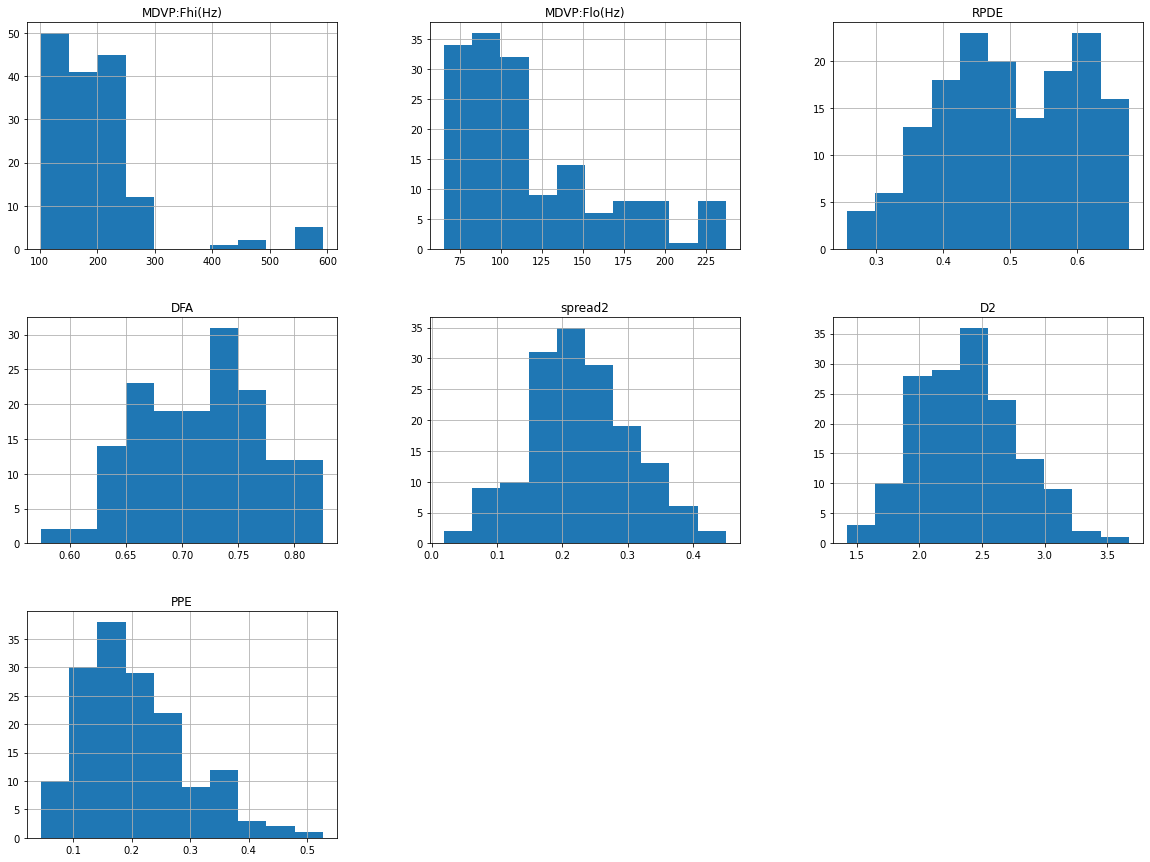

In [26]:
# before
X.hist(figsize=(20, 15))
plt.show()

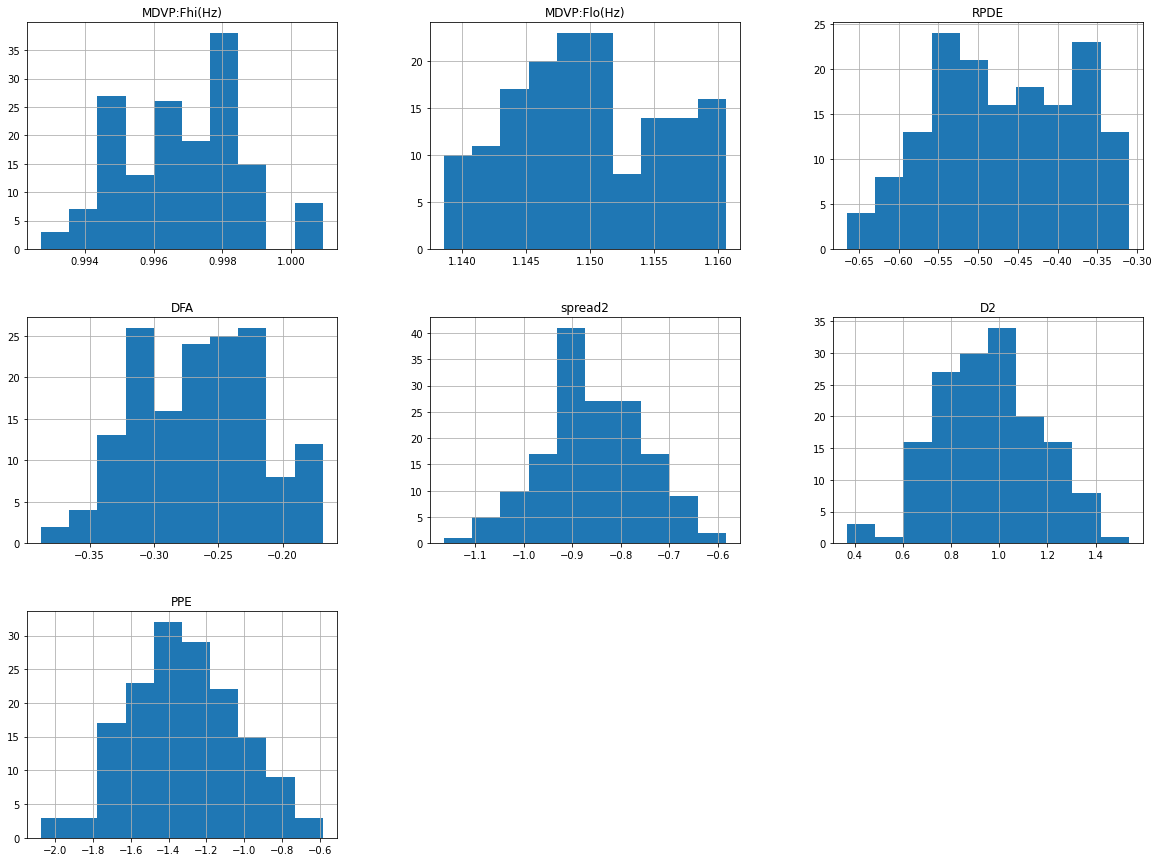

In [27]:
for col in X.columns:
    if all(X[col] > 0):
        transformation, _ = boxcox(X[col])
        X[col] = transformation

# after
X.hist(figsize=(20, 15))
plt.show()

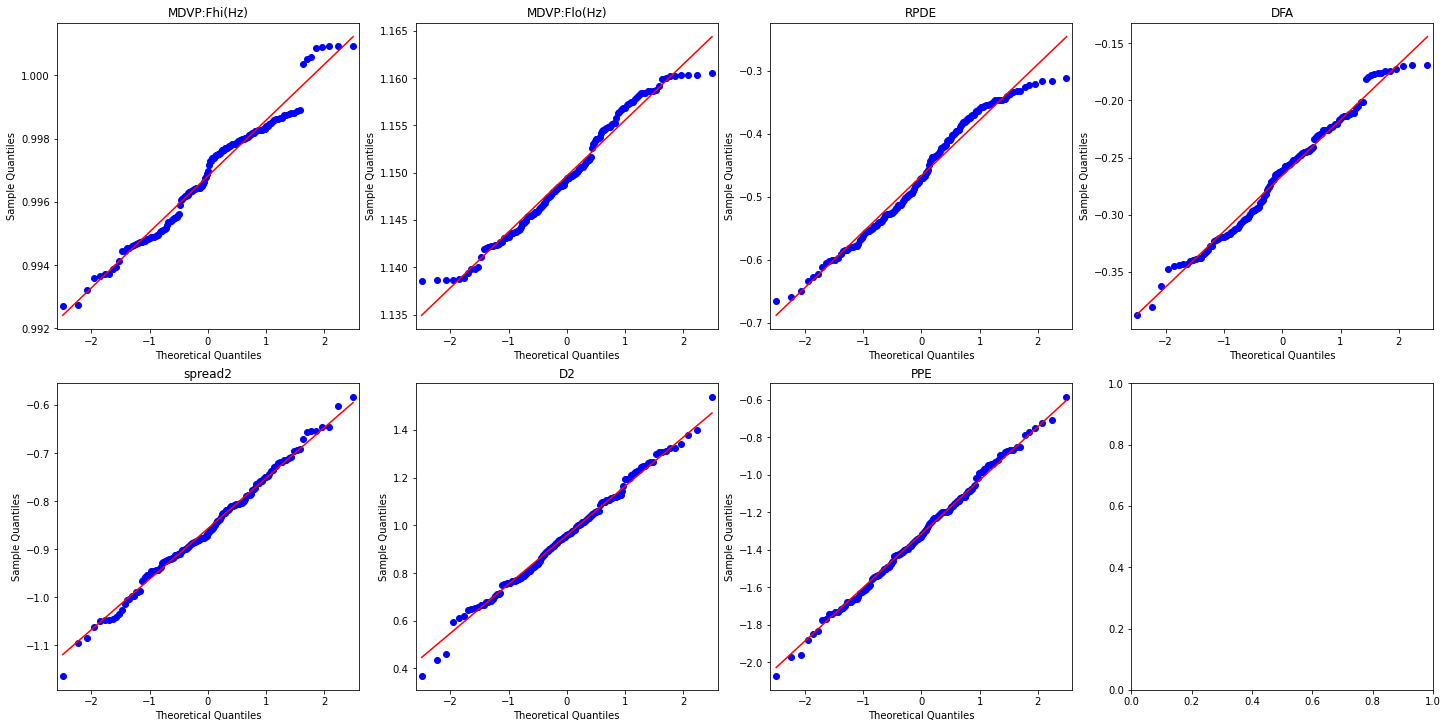

In [28]:
from statsmodels.graphics.gofplots import qqplot

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), constrained_layout=True)

axs = axs.flatten()

for i, col in enumerate(X.columns):
    qqplot(X[col], fmt='b', marker='o', line='s', ax=axs[i])
    axs[i].set_title(col)
    
plt.show()

We can see that the data has some heavy tails. It is difficult to fully normalize the data. However, I think this transformation will do the work.

# 5. Split the data

In [31]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=31)

# split the data in a train set and test set, while preserving the distribution
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=31)
for train_index, test_index in split.split(strat_train_set, strat_train_set['status']):
	temp = strat_train_set.copy()
	strat_train_set = temp.iloc[train_index]
	strat_val_set = temp.iloc[test_index]

1    0.615385
0    0.205128
Name: status, dtype: float64

In [32]:
strat_val_set['status'].value_counts() / len(strat_val_set)

1    0.75
0    0.25
Name: status, dtype: float64

# 6. Conclusion
We analyzed the dataset and saw it was very skewed. We will implement the steps talked about and create multiple datasets containing:
- raw data
- data without correlation
- pca features
- pca features transformed

We hypothesize that we do not have to remove outliers. The biggest variance is among patients with Parkinson's disease. They contain outliers, and it is important to keep these outliers to prevent false negatives.
